/home/miquel/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


(5460, 8192)


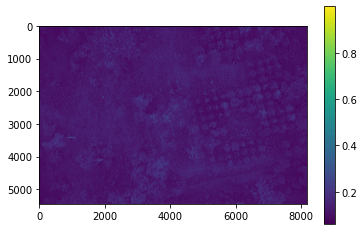

uint8 (5460, 8192, 3)


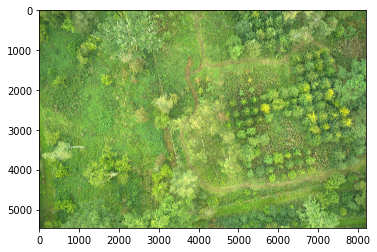

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio.v3 as iio
import rawpy

# TODO 
# Get metadata from JPEG and TIFF (location, camera model, focal length)

raw = rawpy.imread('P1-RGB/DJI_20230927151839_0015.DNG')
print(raw.raw_image.shape)

plt.figure()
plt.imshow(raw.raw_image.astype(np.float64)/2**16)
plt.colorbar()
plt.show()

rgb = raw.postprocess()
print(rgb.dtype, rgb.shape)

plt.figure()
plt.imshow(rgb)
plt.show()

(960, 1280)


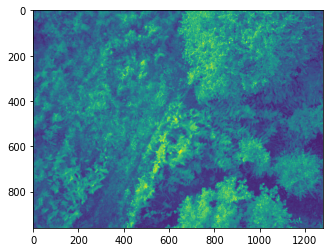

In [3]:
nir_image = iio.imread('MX-nIR/IMG_0198_4.tif')  # Underscores mean different layer (RGB, red edge, near IR)
print(nir_image.shape)

plt.imshow(nir_image)

(1080, 1920, 3)


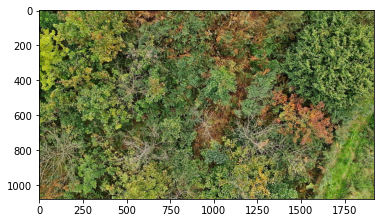

In [86]:
from GPSPhoto import gpsphoto

ir_image = iio.imread('H20N-IR/DJI_20230927132600_0010_W.JPG')
# Three cameras:
#  _W: wide angle
#  _Z: zoom optical
#  _IR: Infrared (500x600 px approx)
print(ir_image.shape)

plt.imshow(ir_image)

In [ ]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from PIL.TiffTags import TAGS as TIFFTAGS
from datetime import datetime, timezone
from pathlib import Path
import pandas as pd

class ImageMetaData:
    '''
    Extract the exif data from any image. Data includes GPS coordinates, 
    Focal Length, Manufacture, and more.
    '''
    exif_data = None
    image = None

    def __init__(self, img_path, focal_length_mm=None):
        extension = Path(img_path).suffix

        self.image = Image.open(img_path)
        if "tif" in extension or "TIF" in extension:
            self.get_tiff_data()
        else:
            self.get_exif_data()
        if focal_length_mm:
            self.exif_data["FocalLength"] = focal_length_mm

    def get_tiff_data(self):
        exif = self.image.getexif()
        self.exif_data = {}
        gps_info = {}
        info = exif.get_ifd(0x8825)
        gps_keys = ['GPSVersionID','GPSLatitudeRef','GPSLatitude','GPSLongitudeRef','GPSLongitude','GPSAltitudeRef','GPSAltitude','GPSTimeStamp','GPSSatellites','GPSStatus','GPSMeasureMode','GPSDOP','GPSSpeedRef','GPSSpeed','GPSTrackRef','GPSTrack','GPSImgDirectionRef','GPSImgDirection','GPSMapDatum','GPSDestLatitudeRef','GPSDestLatitude','GPSDestLongitudeRef','GPSDestLongitude','GPSDestBearingRef','GPSDestBearing','GPSDestDistanceRef','GPSDestDistance','GPSProcessingMethod','GPSAreaInformation','GPSDateStamp','GPSDifferential']
        for k, v in info.items():
            gps_info[gps_keys[k]] = str(v).replace('(','').replace(')','')
        gps_info['GPSLatitude'] = [float(x) for x in gps_info['GPSLatitude'].split(',')]
        gps_info['GPSLongitude'] = [float(x) for x in gps_info['GPSLongitude'].split(',')]
        self.exif_data['GPSInfo'] = gps_info
        self.exif_data['FocalLength'] = exif.get_ifd(0x920a)
        self.exif_data['DateTime'] = exif[306]

    def get_exif_data(self):
        """Returns a dictionary from the exif data of an PIL Image item. Also converts the GPS Tags"""
        exif_data = {}
        info = self.image._getexif()
        if info:
            for tag, value in info.items():
                decoded = TAGS.get(tag, tag)
                #print(decoded, value)
                if decoded == "GPSInfo":
                    gps_data = {}
                    for t in value:
                        sub_decoded = GPSTAGS.get(t, t)
                        gps_data[sub_decoded] = value[t]
                    exif_data[decoded] = gps_data
                else:
                    exif_data[decoded] = value
        self.exif_data = exif_data
        return exif_data

    def get_if_exist(self, data, key):
        if key in data:
            return data[key]
        return None

    def convert_to_degress(self, value):
        """Helper function to convert the GPS coordinates 
        stored in the EXIF to degress in float format"""
        d = float(value[0])
        m = float(value[1])
        s = float(value[2])
        return d + (m / 60.0) + (s / 3600.0)

    def _get_tag(self, tag):
        if tag in self.exif_data:
            return self.exif_data[tag]
        return None

    def get_focal_length(self):
        return self._get_tag('FocalLength')

    def get_focal_length_px(self, sensor_width_mm, image_width_px):
        focal_mm = self.get_focal_length()
        if focal_mm is None:
            return None
        focal_pixel = (focal_mm / sensor_width_mm) * image_width_px
        return focal_pixel

    def get_timestamp(self):
        res = self._get_tag('DateTime')
        if res is None:
            return None
        # Parse the string to a datetime object
        dt_object = datetime.strptime(res, "%Y:%m:%d %H:%M:%S")
        
        # Convert the datetime object to a UTC timestamp
        utc_timestamp = dt_object.replace(tzinfo=timezone.utc).timestamp()
        return utc_timestamp

    def get_lat_lng(self):
        """Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)"""
        lat = None
        lng = None
        alt = None
        #print(exif_data)
        if "GPSInfo" in self.exif_data:      
            gps_info = self.exif_data["GPSInfo"]
            gps_latitude = self.get_if_exist(gps_info, "GPSLatitude")
            gps_latitude_ref = self.get_if_exist(gps_info, 'GPSLatitudeRef')
            gps_longitude = self.get_if_exist(gps_info, 'GPSLongitude')
            gps_longitude_ref = self.get_if_exist(gps_info, 'GPSLongitudeRef')
            gps_altitude = self.get_if_exist(gps_info, 'GPSAltitude')
            gps_altitude_ref = self.get_if_exist(gps_info, 'GPSAltitudeRef')
            if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
                lat = self.convert_to_degress(gps_latitude)
                if gps_latitude_ref != "N":                     
                    lat = 0 - lat
                lng = self.convert_to_degress(gps_longitude)
                if gps_longitude_ref != "E":
                    lng = 0 - lng
            alt = gps_altitude
        return lat, lng, alt



def generate_dataset_csv(base_dir, extension, sensor_width_mm, image_width_px, focal_length_mm=None, output_filename='filelist.csv'):
    folder_path = Path(base_dir)
    image_files = folder_path.rglob('*.' + extension)
    filelist =  list(image_files)
    
    image_names = []
    image_ts = []
    image_lat = []
    image_lon = []
    image_alt = []
    focal_px = None
    for image_file in filelist:
        res = ImageMetaData(image_file, focal_length_mm)
        lat, lon, alt = res.get_lat_lng()
        ts = res.get_timestamp()
        if focal_px is None:
            focal_px = res.get_focal_length_px(sensor_width_mm, image_width_px)
        image_names.append(str(image_file))
        image_ts.append(ts)
        image_lat.append(lat)
        image_lon.append(lon)
        image_alt.append(alt)
    
    df = pd.DataFrame({
        'relative_path': image_names,
        'Timestamp [s]': image_ts,
        'Latitude [deg]': image_lat,
        'Longitude [deg]': image_lon,
        'Altitude [m]': image_alt
    })
    df.to_csv(output_filename)
    print("Written filename", output_filename)

# Sensor H20N is 5.37 x 4.04 mm - working GOOD
generate_dataset_csv('H20N-IR', 'JPG', sensor_width_mm=5.37, image_width_px=1920, output_filename="filelist_H20N-IR.csv")

# Sensor Micasense-MX is 4.8 mm x 3.6 mm, focal length 	5.4 mm - working GOOD
generate_dataset_csv('MX-nIR', 'tif', sensor_width_mm=4.8, image_width_px=1280, focal_length_mm=5.4, output_filename="filelist_MX-nIR.csv")

# Sensor P1 is 35.9 × 24 mm - working GOOD
generate_dataset_csv('P1-RGB', 'JPG', sensor_width_mm=35.9, image_width_px=8192, output_filename="filelist_P1-RGB.csv")